## Predicting Whether The Customer Will Subscribe To Term Deposit

#### Data Description:

The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (‘yes’) or not (‘no’) subscribed.



#### Attribute Information:

* age (numeric)

* job : type of job (categorical: ‘admin.’,’bluecollar’,’entrepreneur’,’housemaid’,’management’,’retired’,’selfemployed’,’services’,’student’,’technician’,’unemployed’,’unknown’)

* marital : marital status (categorical: ‘divorced’,’married’,’single’,’unknown’; note: ‘divorced’ means divorced or widowed)

* education (categorical:‘basic.4y’,’basic.6y’,’basic.9y’,’high.school’,’illiterate’,’professional.course’,’university.degree’,’unknown’)

* default: has credit in default? (categorical: ‘no’,’yes’,’unknown’)

* balance: average yearly balance, in euros (numeric)

* housing: has housing loan? (categorical: ‘no’,’yes’,’unknown’)

* loan: has personal loan? (categorical: ‘no’,’yes’,’unknown’)

* contact: contact communication type (categorical: ‘cellular’,’telephone’)

* day: last contact day of the month (numeric 1 -31)

* month: last contact month of year (categorical: ‘jan’, ‘feb’, ‘mar’, …, ‘nov’, ‘dec’)

* duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). Yet,the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

* previous: number of contacts performed before this campaign and for this client (numeric)

* poutcome: outcome of the previous marketing campaign (categorical:‘failure’,’nonexistent’,’success’)

* target: has the client subscribed a term deposit? (binary: “yes”,”no”)

#### Objective:
The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

### Script

#### imports 

In [1]:
from pyforest import *
import warnings 
warnings.filterwarnings('ignore')
lazy_imports()

['import dash',
 'from sklearn.preprocessing import StandardScaler',
 'from sklearn.decomposition import PCA',
 'from sklearn.model_selection import GridSearchCV',
 'import pandas as pd',
 'from PIL import Image',
 'from sklearn.linear_model import Ridge',
 'import lightgbm as lgb',
 'import matplotlib as mpl',
 'import plotly.express as px',
 'import sklearn',
 'from sklearn.linear_model import LinearRegression',
 'import spacy',
 'from sklearn.model_selection import StratifiedKFold',
 'import torch',
 'import pickle',
 'import xgboost as xgb',
 'import datetime as dt',
 'from sklearn.cluster import KMeans',
 'from sklearn.feature_extraction.text import TfidfVectorizer',
 'import cv2',
 'from sklearn.linear_model import ElasticNetCV',
 'from sklearn.preprocessing import RobustScaler',
 'import altair as alt',
 'from sklearn.impute import SimpleImputer',
 'from openpyxl import load_workbook',
 'from sklearn.preprocessing import OneHotEncoder',
 'from sklearn.ensemble import RandomFores

#### Creating a models folder for saving models 

In [2]:
import os
outdir = 'models'
if not os.path.exists(outdir):
    os.mkdir(outdir)

#### Dataset Into Dataframe

In [3]:
df = pd.read_csv('dataset/train.csv',header = 0)
df.head()

<IPython.core.display.Javascript object>

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


#### Explanatory Data Analysis

##### Information from data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          31647 non-null  int64 
 1   age         31647 non-null  int64 
 2   job         31647 non-null  object
 3   marital     31647 non-null  object
 4   education   31647 non-null  object
 5   default     31647 non-null  object
 6   balance     31647 non-null  int64 
 7   housing     31647 non-null  object
 8   loan        31647 non-null  object
 9   contact     31647 non-null  object
 10  day         31647 non-null  int64 
 11  month       31647 non-null  object
 12  duration    31647 non-null  int64 
 13  campaign    31647 non-null  int64 
 14  pdays       31647 non-null  int64 
 15  previous    31647 non-null  int64 
 16  poutcome    31647 non-null  object
 17  subscribed  31647 non-null  object
dtypes: int64(8), object(10)
memory usage: 4.3+ MB


From the above description ,it is clear that our data no null value .Moreover there are 31647 datapoints.
Hence our data set can is quite clean !

##### checking for data imbalance

In [5]:
df['subscribed'].value_counts()

no     27932
yes     3715
Name: subscribed, dtype: int64

This is clearly a case of data imbalance. While training the model we will be upsampling the datapoints of yes .

##### describe

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,31647.0,22563.972162,13075.936990,2.0,11218.0,22519.0,33879.5,45211.0
age,31647.0,40.957247,10.625134,18.0,33.0,39.0,48.0,95.0
balance,31647.0,1363.890258,3028.304293,-8019.0,73.0,450.0,1431.0,102127.0
day,31647.0,15.835466,8.337097,1.0,8.0,16.0,21.0,31.0
duration,31647.0,258.113534,257.118973,0.0,104.0,180.0,318.5,4918.0
campaign,31647.0,2.765697,3.113830,1.0,1.0,2.0,3.0,63.0
pdays,31647.0,39.576042,99.317592,-1.0,-1.0,-1.0,-1.0,871.0
previous,31647.0,0.574272,2.422529,0.0,0.0,0.0,0.0,275.0


##### Box plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

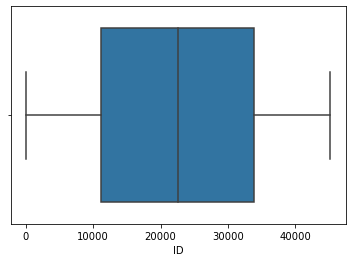

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

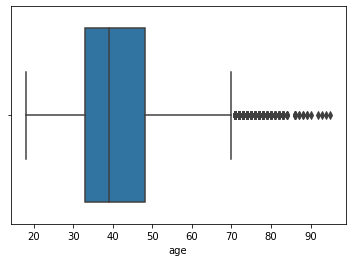

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

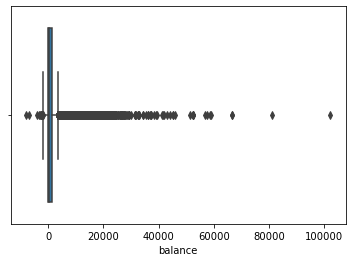

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

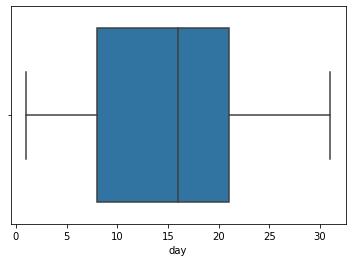

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

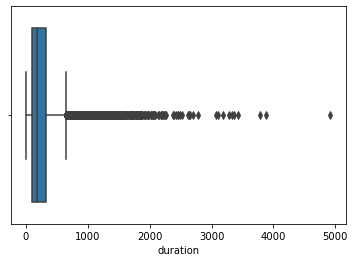

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

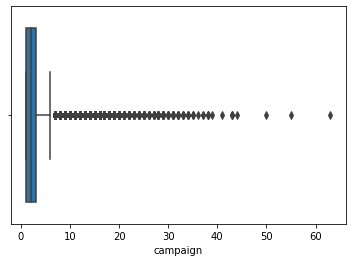

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

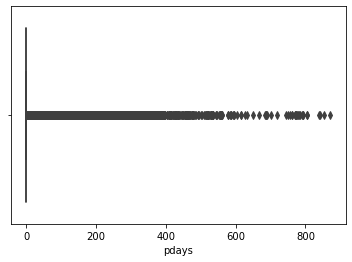

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

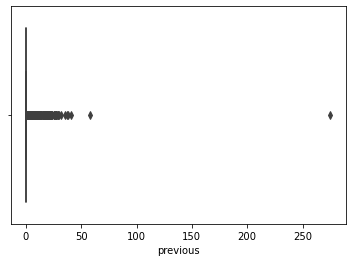

In [7]:
for i in df.describe().columns:
    sns.boxplot(df[i].dropna())
    plt.show()

##### detecting number of outliers

In [8]:
for i,column in enumerate(df.describe().columns):
    Q1 = df[column].quantile(q = 0.25)
    Q3 = df[column].quantile(q = 0.75)
    lower_limit = Q1 - 1.5*(Q3-Q1)
    upper_limit = Q3 + 1.5*(Q3-Q1)
    print('Number of outliers in the upper part of {} : '.format(column),
      df[df[column] > upper_limit][column].count())
    print('Number of outliers in the lower part of {}: '.format(column),
      df[df[column] < lower_limit][column].count()) 

Number of outliers in the upper part of ID :  0
Number of outliers in the lower part of ID:  0
Number of outliers in the upper part of age :  349
Number of outliers in the lower part of age:  0
Number of outliers in the upper part of balance :  3287
Number of outliers in the lower part of balance:  12
Number of outliers in the upper part of day :  0
Number of outliers in the lower part of day:  0
Number of outliers in the upper part of duration :  2288
Number of outliers in the lower part of duration:  0
Number of outliers in the upper part of campaign :  2126
Number of outliers in the lower part of campaign:  0
Number of outliers in the upper part of pdays :  5723
Number of outliers in the lower part of pdays:  0
Number of outliers in the upper part of previous :  5723
Number of outliers in the lower part of previous:  0


Except age, all other attributes have higher number of outliers ,so we will ignore others for now.

##### Treating outliers

In [9]:
columns_to_treat = ['age']
for cols in columns_to_treat:
    Q1 = df[cols].quantile(q = 0.25)
    Q3 = df[cols].quantile(q = 0.75)
    
    lower_limit = Q1 - 1.5*(Q3-Q1)
    upper_limit = Q3 + 1.5*(Q3-Q1)
    
    df.loc[(df[cols] >upper_limit) | (df[cols] < lower_limit),cols] = df[cols].median() 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

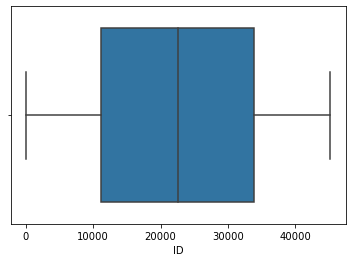

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

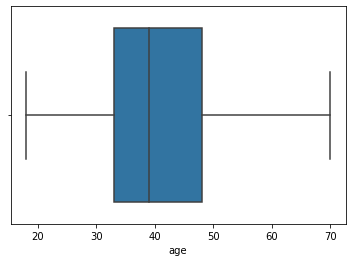

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

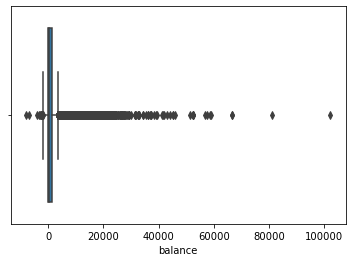

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

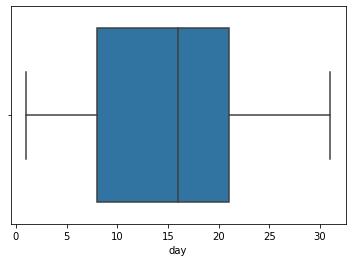

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

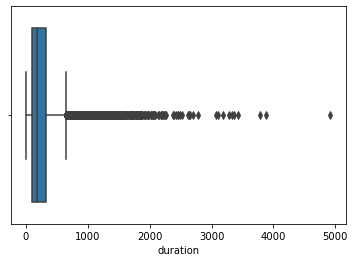

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

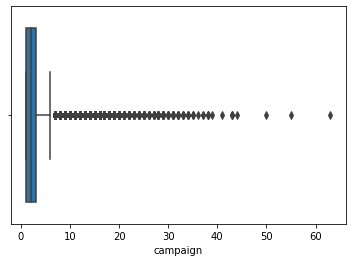

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

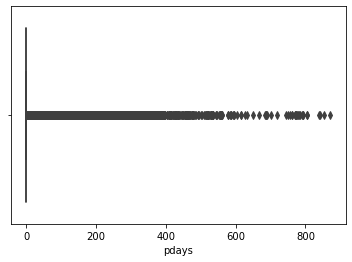

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

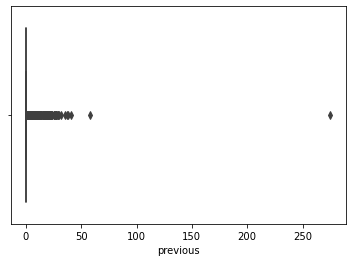

In [10]:
for i in df.describe().columns:
    sns.boxplot(df[i].dropna())
    plt.show()

##### Density plot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

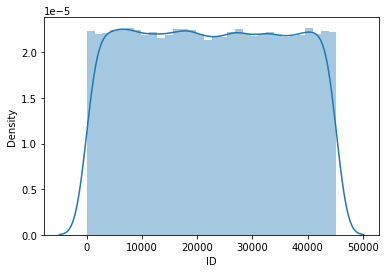

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

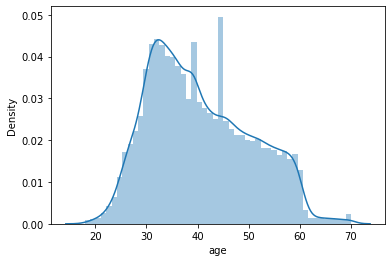

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

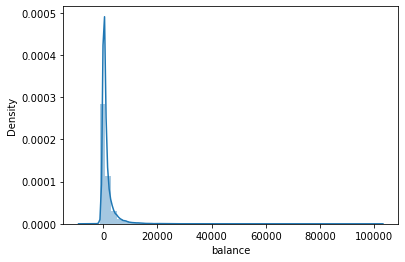

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

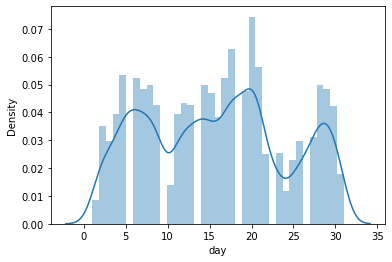

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

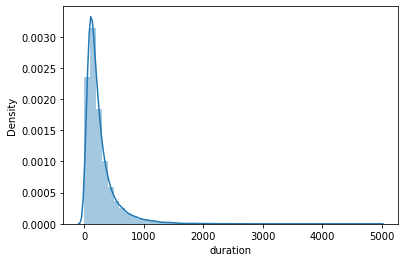

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

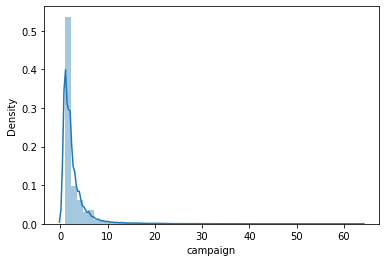

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

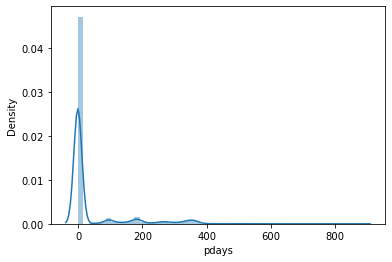

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

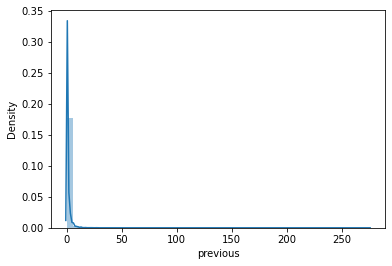

In [11]:
for i in df.describe().columns:
    sns.distplot(df[i].dropna())
    plt.show()

##### countplot for categorical variable

blue-collar      6842
management       6639
technician       5307
admin.           3631
services         2903
retired          1574
self-employed    1123
entrepreneur     1008
unemployed        905
housemaid         874
student           635
unknown           206
Name: job, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

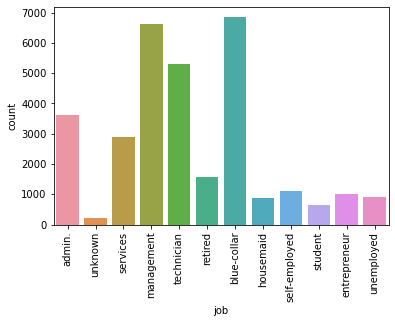

married     19095
single       8922
divorced     3630
Name: marital, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

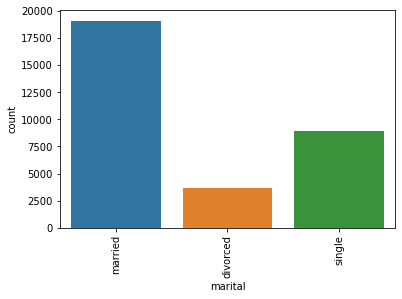

secondary    16224
tertiary      9301
primary       4808
unknown       1314
Name: education, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

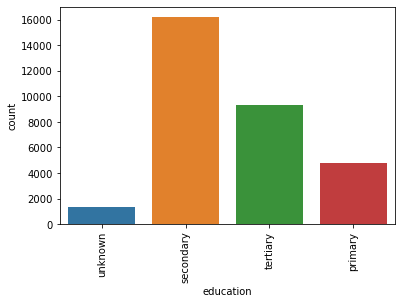

no     31062
yes      585
Name: default, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

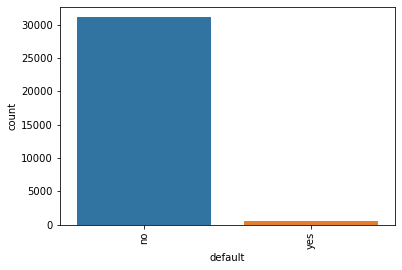

yes    17584
no     14063
Name: housing, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

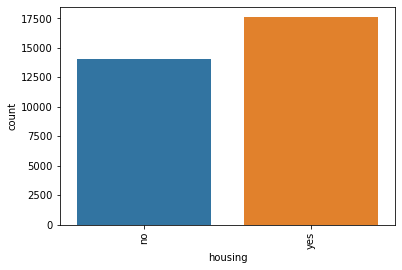

no     26516
yes     5131
Name: loan, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

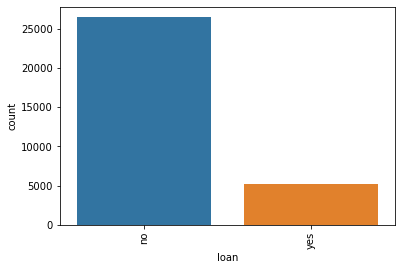

cellular     20423
unknown       9177
telephone     2047
Name: contact, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

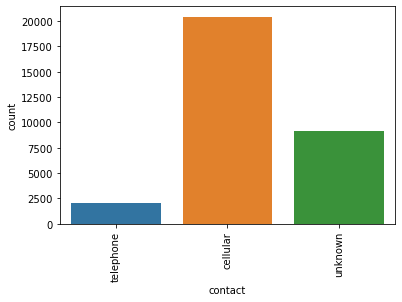

may    9669
jul    4844
aug    4333
jun    3738
nov    2783
apr    2055
feb    1827
jan     977
oct     512
sep     410
mar     342
dec     157
Name: month, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

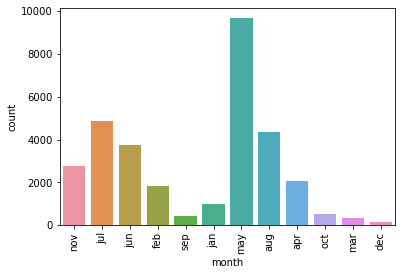

unknown    25929
failure     3362
other       1288
success     1068
Name: poutcome, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

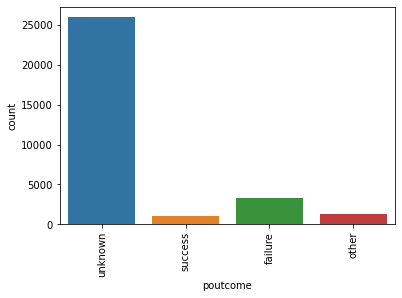

no     27932
yes     3715
Name: subscribed, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

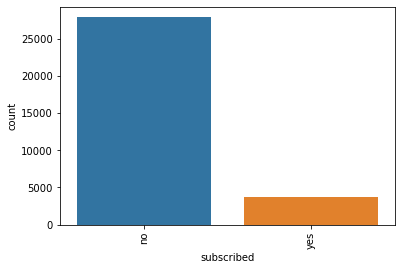

In [12]:
categories = ['job','marital','education','default','housing','loan','contact','month','poutcome','subscribed']

for i in categories:
    print(df[i].dropna().value_counts())
    sns.countplot(df[i].dropna())
    plt.xticks(rotation = 90)
    plt.show()

##### correlation

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

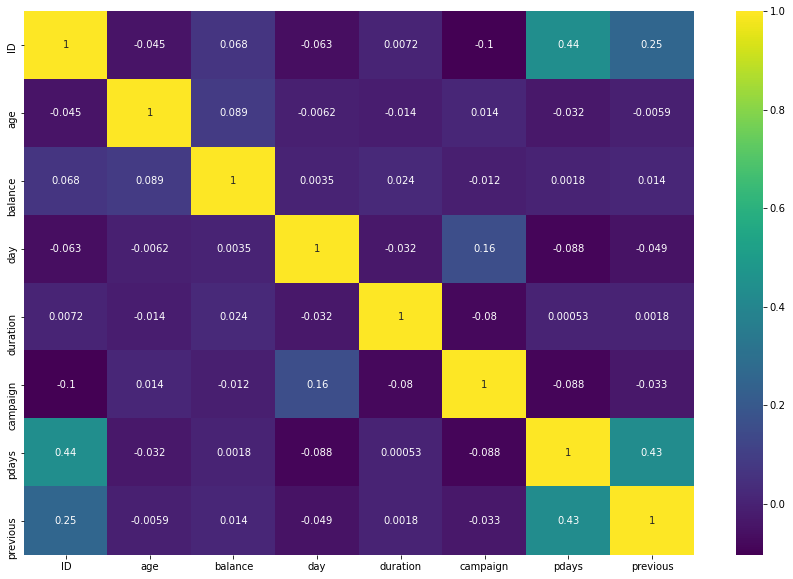

In [13]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(),annot = True,cmap = 'viridis')

##### scatterplot

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

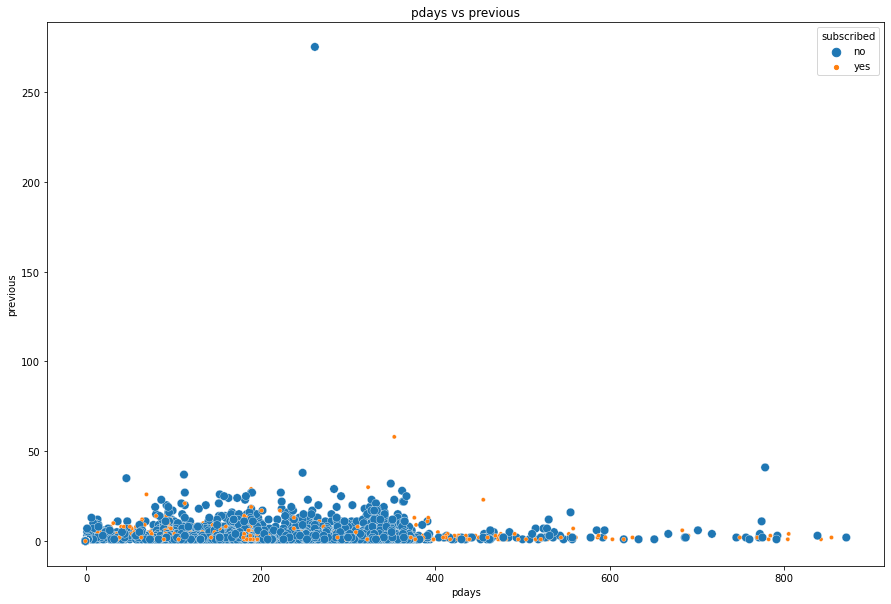

In [14]:
# pdays vs previous

plt.figure(figsize = (15,10))
plt.title('pdays vs previous')
plt.xlabel('pdays')
plt.ylabel('previous')
#plt.xticks(rotation = 90)
sns.scatterplot(data = df, x = 'pdays',y = 'previous',hue = 'subscribed',size = 'subscribed')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

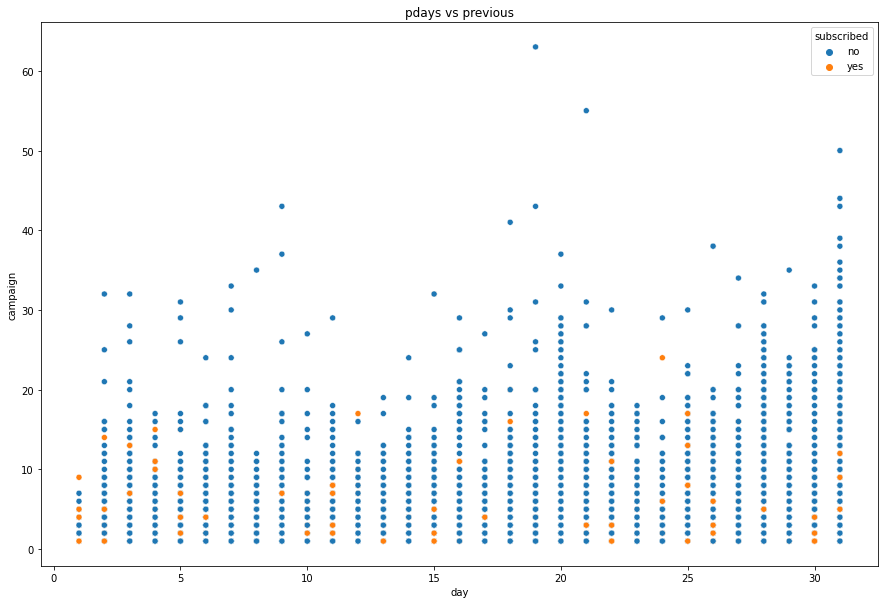

In [15]:
# day vs campaign

plt.figure(figsize = (15,10))
plt.title('pdays vs previous')
plt.xlabel('day')
plt.ylabel('campaign')
#plt.xticks(rotation = 90)
sns.scatterplot(data = df, x = 'day',y = 'campaign',hue = 'subscribed')
plt.show()

##### Upsampling imbalance datapoints

In [16]:
from sklearn.utils import resample

sub = df[df['subscribed'] == 'yes']
notsub = df[df['subscribed'] == 'no']

print(sub.shape,notsub.shape)

upsampled_sub = resample(sub, replace = True, n_samples = len(notsub),random_state = 13)

upsampled_df = pd.concat([notsub,upsampled_sub])
upsampled_df.subscribed.value_counts()

(3715, 18) (27932, 18)


<IPython.core.display.Javascript object>

yes    27932
no     27932
Name: subscribed, dtype: int64

##### Test Train Split

In [17]:
X = upsampled_df.drop(['subscribed','ID'],axis = 1) # ID is just a primary key for imcluding it will not be beneficial.
y = upsampled_df.subscribed

print(X.info())

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 13)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55864 entries, 0 to 25138
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        55864 non-null  float64
 1   job        55864 non-null  object 
 2   marital    55864 non-null  object 
 3   education  55864 non-null  object 
 4   default    55864 non-null  object 
 5   balance    55864 non-null  int64  
 6   housing    55864 non-null  object 
 7   loan       55864 non-null  object 
 8   contact    55864 non-null  object 
 9   day        55864 non-null  int64  
 10  month      55864 non-null  object 
 11  duration   55864 non-null  int64  
 12  campaign   55864 non-null  int64  
 13  pdays      55864 non-null  int64  
 14  previous   55864 non-null  int64  
 15  poutcome   55864 non-null  object 
dtypes: float64(1), int64(6), object(9)
memory usage: 7.2+ MB
None


<IPython.core.display.Javascript object>

##### Catboost Model

In [18]:
from catboost import CatBoostClassifier

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features':[1,2,3,4,6,7,8,10,15],# need to be handled or encoded
          'verbose':200,
          'random_seed':13}

catmodel = CatBoostClassifier(**params).fit(X_train,y_train,eval_set = (X_test,y_test),use_best_model = True)

Learning rate set to 0.079724
0:	test: 0.8709463	best: 0.8709463 (0)	total: 226ms	remaining: 3m 45s
200:	test: 0.9497500	best: 0.9497500 (200)	total: 10.3s	remaining: 41s
400:	test: 0.9600291	best: 0.9600291 (400)	total: 21.3s	remaining: 31.9s
600:	test: 0.9658946	best: 0.9658946 (600)	total: 31.6s	remaining: 21s
800:	test: 0.9702767	best: 0.9702767 (800)	total: 40.8s	remaining: 10.1s
999:	test: 0.9734211	best: 0.9734305 (998)	total: 50s	remaining: 0us

bestTest = 0.9734304551
bestIteration = 998

Shrink model to first 999 iterations.


##### Feature Importance

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Feature Importance')

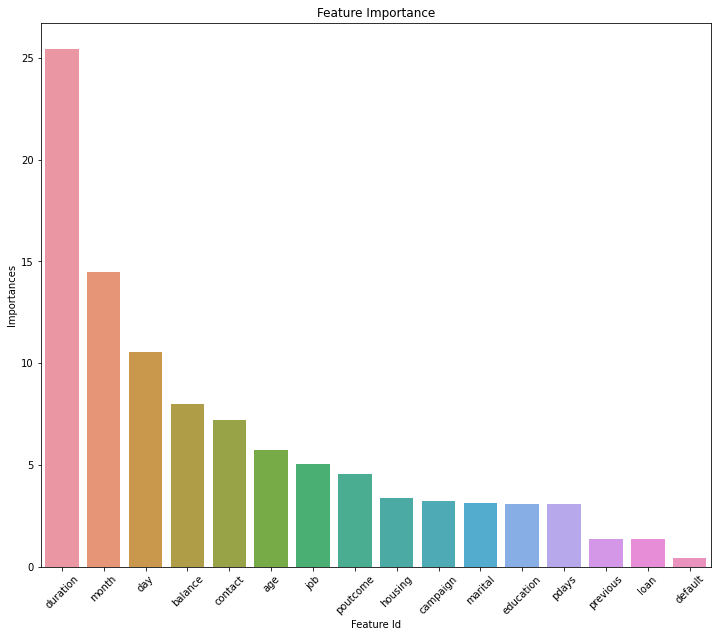

In [19]:
feature_imp = catmodel.get_feature_importance(prettified = True)

plt.figure(figsize = (12,10))
sns.barplot(data = feature_imp, x = 'Feature Id', y = 'Importances')
plt.xticks(rotation = 45)
plt.title('Feature Importance')

Here Duration affects the subscription class the highest. But for practical prediction , we will ignore duration factor as mentioned in the description !.

##### Rebuilding catmodel

In [20]:
X = upsampled_df.drop(['subscribed','duration','ID'],axis = 1) # dropping duration
y = upsampled_df.subscribed

print(X.info())

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state = 13)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55864 entries, 0 to 25138
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        55864 non-null  float64
 1   job        55864 non-null  object 
 2   marital    55864 non-null  object 
 3   education  55864 non-null  object 
 4   default    55864 non-null  object 
 5   balance    55864 non-null  int64  
 6   housing    55864 non-null  object 
 7   loan       55864 non-null  object 
 8   contact    55864 non-null  object 
 9   day        55864 non-null  int64  
 10  month      55864 non-null  object 
 11  campaign   55864 non-null  int64  
 12  pdays      55864 non-null  int64  
 13  previous   55864 non-null  int64  
 14  poutcome   55864 non-null  object 
dtypes: float64(1), int64(5), object(9)
memory usage: 6.8+ MB
None


<IPython.core.display.Javascript object>

In [21]:
from catboost import CatBoostClassifier

params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features':[1,2,3,4,6,7,8,10,14],# need to be handled or encoded
          'verbose':200,
          'random_seed':13}

catmodel_up = CatBoostClassifier(**params).fit(X_train,y_train,eval_set = (X_test,y_test),use_best_model = True)

Learning rate set to 0.079724
0:	test: 0.7310174	best: 0.7310174 (0)	total: 58.9ms	remaining: 58.8s
200:	test: 0.8581142	best: 0.8581142 (200)	total: 8.94s	remaining: 35.5s
400:	test: 0.8881664	best: 0.8881664 (400)	total: 17.6s	remaining: 26.3s
600:	test: 0.9042664	best: 0.9042664 (600)	total: 26.5s	remaining: 17.6s
800:	test: 0.9169714	best: 0.9169714 (800)	total: 35.8s	remaining: 8.9s
999:	test: 0.9256905	best: 0.9256905 (999)	total: 45.3s	remaining: 0us

bestTest = 0.9256904783
bestIteration = 999



#### Evaluation Catboost

In [22]:
# accuracy: (tp + tn) / (p + n)
print("Training accuracy for CatBoost is : " , metrics.accuracy_score(y_train,catmodel_up.predict(X_train)))
print("Training accuracy for CatBoost is : " ,  metrics.confusion_matrix(y_train, catmodel_up.predict(X_train)))

# precision tp / (tp + fp)
precision_train = metrics.precision_score(y_train, catmodel_up.predict(X_train),average=None)
print('Precision train: ' , precision_train)

# recall: tp / (tp + fn)
recall_train = metrics.recall_score(y_train, catmodel_up.predict(X_train),average=None)
print('Recall train: ' , recall_train)

# f1: 2 tp / (2 tp + fp + fn)
f1_train = metrics.f1_score(y_train, catmodel_up.predict(X_train),average=None)
print('F1 score train: ' , f1_train)

# accuracy: (tp + tn) / (p + n)
print("Test accuracy for CatBoost is : " , metrics.accuracy_score(y_test, catmodel_up.predict(X_test)))
print("Test accuracy for CatBoost is : " ,  metrics.confusion_matrix(y_test, catmodel_up.predict(X_test)))

# precision tp / (tp + fp)
precision_test = metrics.precision_score(y_test, catmodel_up.predict(X_test),average=None)
print('Precision test: ', precision_test)

# recall: tp / (tp + fn)
recall_test = metrics.recall_score(y_test, catmodel_up.predict(X_test),average=None)
print('Recall test: ' , recall_test)

# f1: 2 tp / (2 tp + fp + fn)
f1_test = metrics.f1_score(y_test, catmodel_up.predict(X_test),average=None)
print('F1 score test: ' , f1_test)

<IPython.core.display.Javascript object>

Training accuracy for CatBoost is :  0.8787770299298295


<IPython.core.display.Javascript object>

Training accuracy for CatBoost is :  [[18880  2133]
 [ 2946 17939]]


<IPython.core.display.Javascript object>

Precision train:  [0.86502337 0.89373256]


<IPython.core.display.Javascript object>

Recall train:  [0.89849141 0.85894182]


<IPython.core.display.Javascript object>

F1 score train:  [0.88143981 0.87599189]


<IPython.core.display.Javascript object>

Test accuracy for CatBoost is :  0.8466991264499498


<IPython.core.display.Javascript object>

Test accuracy for CatBoost is :  [[5956  963]
 [1178 5869]]


<IPython.core.display.Javascript object>

Precision test:  [0.83487525 0.85904567]


<IPython.core.display.Javascript object>

Recall test:  [0.86081804 0.83283667]


<IPython.core.display.Javascript object>

F1 score test:  [0.84764819 0.84573817]


#### Using Base Model for comparision

#### Scaling and Encoding

In [23]:
from sklearn.compose import ColumnTransformer

ss = StandardScaler()
enc = OneHotEncoder(handle_unknown='ignore')
columnTransformer = ColumnTransformer([('encoder',
                                        OneHotEncoder(),
                                        [1,2,3,4,6,7,8,10,14])],
                                      remainder='passthrough')

X_train = columnTransformer.fit_transform(X_train)
X_train = ss.fit_transform(X_train)

# scaling and encoding X_test
X_test = columnTransformer.transform(X_test)
X_test = ss.transform(X_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### Logistic Regression

In [24]:
logit = LogisticRegression().fit(X_train,y_train)

<IPython.core.display.Javascript object>

##### Evaluation Logistic Regression

In [25]:
# accuracy: (tp + tn) / (p + n)
print("Training accuracy for Logistic Regression is : " , metrics.accuracy_score(y_train,logit.predict(X_train)))
print("Training accuracy for Logistic Regression is : " ,  metrics.confusion_matrix(y_train, logit.predict(X_train)))

# precision tp / (tp + fp)
precision_train = metrics.precision_score(y_train, logit.predict(X_train),average=None)
print('Precision train: ' , precision_train)

# recall: tp / (tp + fn)
recall_train = metrics.recall_score(y_train, logit.predict(X_train),average=None)
print('Recall train: ' , recall_train)

# f1: 2 tp / (2 tp + fp + fn)
f1_train = metrics.f1_score(y_train, logit.predict(X_train),average=None)
print('F1 score train: ' , f1_train)

# accuracy: (tp + tn) / (p + n)
print("Test accuracy for Logistic Regression is : " , metrics.accuracy_score(y_test, logit.predict(X_test)))
print("Test accuracy for Logistic Regression is : " ,  metrics.confusion_matrix(y_test, logit.predict(X_test)))

# precision tp / (tp + fp)
precision_test = metrics.precision_score(y_test, logit.predict(X_test),average=None)
print('Precision test: ', precision_test)

# recall: tp / (tp + fn)
recall_test = metrics.recall_score(y_test, logit.predict(X_test),average=None)
print('Recall test: ' , recall_test)

# f1: 2 tp / (2 tp + fp + fn)
f1_test = metrics.f1_score(y_test, logit.predict(X_test),average=None)
print('F1 score test: ' , f1_test)

<IPython.core.display.Javascript object>

Training accuracy for Logistic Regression is :  0.7023724282781995


<IPython.core.display.Javascript object>

Training accuracy for Logistic Regression is :  [[16138  4875]
 [ 7595 13290]]


<IPython.core.display.Javascript object>

Precision train:  [0.67998146 0.73162675]


<IPython.core.display.Javascript object>

Recall train:  [0.76800076 0.63634187]


<IPython.core.display.Javascript object>

F1 score train:  [0.72131587 0.68066581]


<IPython.core.display.Javascript object>

Test accuracy for Logistic Regression is :  0.6992696548761277


<IPython.core.display.Javascript object>

Test accuracy for Logistic Regression is :  [[5325 1594]
 [2606 4441]]


<IPython.core.display.Javascript object>

Precision test:  [0.67141596 0.73587407]


<IPython.core.display.Javascript object>

Recall test:  [0.76961989 0.63019725]


<IPython.core.display.Javascript object>

F1 score test:  [0.71717172 0.67894817]


##### Hence we saw Catboost classifier performed the best when compared with logistic Regression model (Base model).I haven't tried other  ensemble method over Catboost believing that Catboost will be higher in  most cases.

##### Also hypertuning the catboost will improve the accuracy relatively,so we can also explore some !

#### Saving models for future use 

In [26]:
import joblib

joblib.dump(catmodel_up, 'models/CatBoost_model.pkl')
joblib.dump(logit, 'models/Logistic_Regression_model.pkl')
joblib.dump(columnTransformer, 'models/ColumnTransformer_model.pkl')
joblib.dump(ss, 'models/StandardScaler_model.pkl')

['models/StandardScaler_model.pkl']